## Optimization with `gradpy`

At the core of therapy planning for IMRT is an optimization problem which answers the following question: What are the optimal parameters, i.e. beam intensities and collimator positions, for which a radiation dose can be delivered as close to the desired dose for a given region, respecting any additional constraints, such as maximum and minimum local doses? Such questions are commonly framed as minimizations of a cost or objective function which penalizes deviations from the target, as well as failure to satisfy imposed constraints.

This framework for solving optimization problems is quite general, and has been addressed by a variety of numerical optimization methods. As typical cost functions may be nonlinear with respect to the parameters to optimize, we implement the [Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm), an iterative method used to solve nonlinear optimization problems. The BFGS algorithm relies on an available gradient of the objective function, to be provided by automatic differentiation using the `gradpy` package, and builds an improved estimate of the Hessian matrix at each iteration using the current solution and gradient information.

In the following example, we illustrate the use of our BFGS implementation with `gradpy` to find the optimal parameters of a polynomial fit to data. We start by importing the relevant modules and define a set of random $(x,y)$ data points to fit by a polynomial:

In [2]:
from gradpy.autodiff import Var
from therapy_planner.bfgs import BFGS
import numpy as np

data = np.array([[-2.9902373, 2.98118975],
                 [-2.29029546, 10.58188901],
                 [-1.64611399, 7.63332972],
                 [-0.99102336, 5.20796568],
                 [-0.34860237, 4.60892615],
                 [ 0.36251216, 6.58063876],
                 [ 0.98751744, 6.74456028],
                 [ 1.74502127, 4.1763449 ],
                 [ 2.42606589, 1.80673973],
                 [ 2.9766883, 9.29002312]])

Next we define functions that will comprise the overall cost to minimize. `MS_error` computes the mean squared error between the target $y$ and the polynomial fit `poly`. `L2_reg` is an L-2 regularization on the model parameters with weight alpha.

In [3]:
def poly(x,params):
    return params[0] + sum([params[i]*x**i for i in range(1,len(params))])

def MS_error(x,y,params):
    return sum([(poly(xi,params) - yi)**2 for xi,yi in zip(x,y)])

def L2_reg(alpha,params):
    return alpha*sum([p**2 for p in params])

We choose a polynomial order and define a list of the corresponding number of parameters needed. The cost function is defined as a sum of the mean squared error and regularization contributions. As the cost is a function of `Var()` objects in the `params` list, it is a differentiable `autodiff` object.

In [4]:
order = 5
params = [Var() for _ in range(order+1)]

alpha = 0.1
cost = MS_error(data[:,0],data[:,1],params) + L2_reg(alpha,params)

Using the implemented BFGS algorithm, we pass in the function to minimize (`cost`), parameters on which it depends (`params`), and an initial guess for each parameter. As `params` is a list of `Var` objects, the values are updated in place. The optimization returns the final step size and number of iterations performed, reporting `Minimum found` if the minimum is successfully obtained within the specified minimum step size tolerance.

In [5]:
step, Niter, found = BFGS(cost,params,np.ones(len(params)))
fit_params = [p.value for p in params] # extract fitted parameters

Minimum found.


Finally, we visualize the data and the fit.

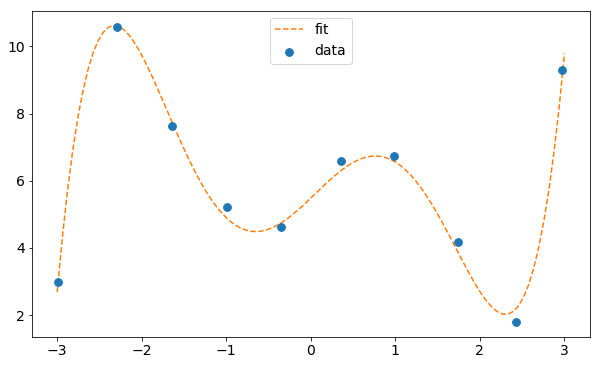

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.scatter(data[:,0],data[:,1],label='data',zorder=3,s=60)
x = np.linspace(-3,3,100)
ax.plot(x,poly(x,fit_params),linestyle='dashed',color='C1',label='fit')
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='upper center',fontsize=14)
plt.show()